# PINN Solution of the Belousov-Zhabotinsky equation
This PyTorch code demonstrates the application of physically-informed neural networks (PINN) in the solution of a well-known Belousov-Zhabotinsky equation with periodic boundary condition
\begin{aligned}
  &u_t = \epsilon_1u_{xx}+u + v - uv - u^2 , \quad (t, x) \in [0, T]\times[-L, L]\\
  &v_t = \epsilon_2 v_{xx}+w - v - uv,\\
  &w_t = \epsilon_1 w_{xx}+u - w.\\
  &u(0, x) = u_0(x), \quad \forall x \in [-L, L] \\
  &v(0, x) = v_0(x), \quad \forall x \in [-L, L] \\
  &w(0, x) = w_0(x), \quad \forall x \in [-L, L] \\
  &u(t, -L) = u(t, L), \quad u_x(t, -L) = u_x(t, L), \\
   &v(t, -L) = v(t, L), \quad v_x(t, -L) = v_x(t, L), \\
    &w(t, -L) = w(t, L), \quad w_x(t, -L) = w_x(t, L), \quad \forall t \in [0, T]
\end{aligned}
where $\epsilon_1, \epsilon_2> 0$ are some parameters, and $[x_{\min}, x_{\max}]$ covers one full period.

## Libraries and Dependencies

In [2]:
import torch
import torch.optim
import torch.optim.lr_scheduler as lr_scheduler
from itertools import chain
from collections import OrderedDict
from pyDOE import lhs
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
# set the random seed
np.random.seed(1234)

In [5]:
# MPS or CUDA or CPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
#
print(f"Working on {device}")

Working on mps


In [6]:
ep1 = 1e-5
ep2 = 2e-5

L = 1.0
xlo = -L
xhi = L
period = xhi - xlo
tlo = 0.0
thi = 3.0
pi_ten = torch.tensor(np.pi).float().to(device)
L_ten = torch.tensor(L).float().to(device)
u0 = lambda x: np.exp(-100*np.power((x+.5),2))
u0_ten = lambda x: torch.exp(-100*torch.pow((x+.5),2))
v0 = lambda x: np.exp(-100*np.power((x),2))
v0_ten = lambda x: torch.exp(-100*torch.pow((x),2))
w0 = lambda x: np.exp(-100*np.power((x-.5),2))
w0_ten = lambda x: torch.exp(-100*torch.pow((x-.5),2))

## Physics-informed Neural Networks

In [7]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        # parameters
        self.depth = len(layers) - 1
        # set up layer order dict
        self.activation = torch.nn.Tanh
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
    def forward(self, x):
        out = self.layers(x)
        return out

In [8]:
# the physics-guided neural network
# we will use built-in transformation to make it 
# periodic by default
class PhysicsInformedNN():
    def __init__(self, period, m, X_PDE, layers, ep1, ep2):
        # Prepare the periodic layer
        m_vec = np.expand_dims(np.arange(1, m + 1), axis = 0)
        self.ms = torch.tensor(2.0 * np.pi/period * m_vec).float().to(device)
        # PDE data, gradients will be computed on these points so requires_grad = True
        self.t_PDE = torch.tensor(X_PDE[:, 0:1], requires_grad=True).float().to(device)
        self.x_PDE = torch.tensor(X_PDE[:, 1:2], requires_grad=True).float().to(device)
        # layers to build Neural Net
        # changing the input variables for periodic layer
        # m cosines, m sines, and 1 costant, and 1 t
        layers[0] = int(2 * m + 2)
        self.layers = layers
        # equation related parameters
        self.ep1 = ep1
        self.ep2 = ep2
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)    
        # prepare the optimizer
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), lr = 1e-3)
        self.optimizer_LBFGS = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=10000, 
            max_eval=5000, 
            history_size=50,
            tolerance_grad=1e-7, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )        
        self.iter = 0
    # evaluater neural network
    def NN_eval(self, t, x):  
        x_trans = torch.matmul(x, self.ms)
        NN = self.dnn(torch.cat([t, torch.ones_like(x), torch.cos(x_trans), torch.sin(x_trans)], dim = 1))
        uNN = NN[:, 0][:, None]
        vNN = NN[:, 1][:, None]
        wNN = NN[:, 2][:, None]
        u0_torch = u0_ten(x)
        v0_torch = v0_ten(x)
        w0_torch = w0_ten(x)
        u = u0_torch*torch.exp(-t) + t * uNN
        v = v0_torch*torch.exp(-t) + t * vNN
        w = w0_torch*torch.exp(-t) + t * wNN
        return u,v,w
    # compute the PDE
    def pde_eval(self, t, x):
        """ The pytorch autograd version of calculating residual """
        u, v, w    = self.NN_eval(t, x)
        # compute the derivatives for u
        u_t  = torch.autograd.grad(u,   t, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        u_x  = torch.autograd.grad(u,   x, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        v_t  = torch.autograd.grad(v,   t, grad_outputs = torch.ones_like(v), retain_graph = True, create_graph=True)[0]
        v_x  = torch.autograd.grad(v,   x, grad_outputs = torch.ones_like(v), retain_graph = True, create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs = torch.ones_like(v), retain_graph = True, create_graph=True)[0]
        w_t  = torch.autograd.grad(w,   t, grad_outputs = torch.ones_like(w), retain_graph = True, create_graph=True)[0]
        w_x  = torch.autograd.grad(w,   x, grad_outputs = torch.ones_like(w), retain_graph = True, create_graph=True)[0]
        w_xx = torch.autograd.grad(w_x, x, grad_outputs = torch.ones_like(w), retain_graph = True, create_graph=True)[0]
    
        Eq1  = u_t - self.ep1 * u_xx - u - v + u * v + torch.pow(u, 2)
        Eq2  = v_t - self.ep2 * v_xx - w + v + u * v
        Eq3  = w_t - self.ep1 * w_xx - u + w
        return Eq1,Eq2,Eq3
    # compute the total loss for the second-order optimizer
    def loss_func(self):
        # reset the gradient
        self.optimizer_LBFGS.zero_grad()
        # compute PDE loss
        pde1_pred, pde2_pred, pde3_pred = self.pde_eval(self.t_PDE, self.x_PDE)
        loss_PDE1 = torch.mean(torch.square(pde1_pred))
        loss_PDE2 = torch.mean(torch.square(pde2_pred))
        loss_PDE3 = torch.mean(torch.square(pde3_pred))
        # compute the total loss, it can be weighted
        loss = loss_PDE1 + loss_PDE2 + loss_PDE3
      
      
        # backward propagation
        loss.backward()
        # increase the iteration counter
        self.iter += 1
        # output
        # output the progress
        if self.iter % 1000 == 0:
            print('Iter %5d, PDE: %10.4e' % (self.iter, loss.item()))       
        return loss
    #
    def train(self, nIter):
        # start the training with Adam first
        self.dnn.train()
        for epoch in range(nIter):
            # compute PDE loss
            pde1_pred, pde2_pred, pde3_pred = self.pde_eval(self.t_PDE, self.x_PDE)
            loss_PDE1 = torch.mean(torch.square(pde1_pred))
            loss_PDE2 = torch.mean(torch.square(pde2_pred))
            loss_PDE3 = torch.mean(torch.square(pde3_pred))
            # compute the total loss, it can be weighted
            loss = loss_PDE1 + loss_PDE2 + loss_PDE3
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step() 
            # output the progress
            if (epoch + 1) % 1000 == 0:
                print('Iter %5d, Total: %10.4e' % (epoch + 1, loss.item()))
        # Backward and optimize
        self.optimizer_LBFGS.step(self.loss_func)                
    #        
    def predict(self, X):
        t = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        x = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.dnn.eval()
        u, v, w = self.NN_eval(t, x)
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        w = w.detach().cpu().numpy()
       
        return u,v,w

## Configurations

In [9]:
# construct the points
def get_points_for_training(tlo, thi, xlo, xhi, N_PDE):
    # for collocation pts, (t, x) \in (0, T)x\Omega
    pts_rand = lhs(2, N_PDE)
    t_PDE = tlo + (thi - tlo) * pts_rand[:, 0:1]
    x_PDE = xlo + (xhi - xlo) * pts_rand[:, 1:2]
    ptsPDE = np.hstack((t_PDE, x_PDE))
    return ptsPDE

## Training

In [10]:
layers = [2, 32, 32, 32, 32, 32, 32, 3]
m = 10
N_IC = 64
N_PDE = int(64 * 64)
ptsPDE = get_points_for_training(tlo, thi, xlo, xhi, N_PDE)
model = PhysicsInformedNN(period, m, ptsPDE, layers, ep1, ep2)
model.train(50000)

Iter  1000, Total: 6.8672e-04
Iter  2000, Total: 2.8858e-04
Iter  3000, Total: 1.7959e-04
Iter  4000, Total: 1.6278e-04
Iter  5000, Total: 1.2057e-04
Iter  6000, Total: 9.3493e-05
Iter  7000, Total: 9.7540e-05
Iter  8000, Total: 5.9005e-05
Iter  9000, Total: 4.5770e-05
Iter 10000, Total: 9.3745e-05
Iter 11000, Total: 8.5601e-05
Iter 12000, Total: 2.7598e-05
Iter 13000, Total: 2.9772e-05
Iter 14000, Total: 4.4373e-05
Iter 15000, Total: 2.0145e-05
Iter 16000, Total: 1.8315e-05
Iter 17000, Total: 1.4749e-05
Iter 18000, Total: 6.2230e-05
Iter 19000, Total: 4.1125e-05
Iter 20000, Total: 1.2735e-05
Iter 21000, Total: 1.1298e-05
Iter 22000, Total: 9.7275e-06
Iter 23000, Total: 1.4989e-05
Iter 24000, Total: 3.4408e-04
Iter 25000, Total: 9.7343e-06
Iter 26000, Total: 1.1934e-05
Iter 27000, Total: 5.9038e-05
Iter 28000, Total: 1.0672e-05
Iter 29000, Total: 3.0333e-05
Iter 30000, Total: 6.2307e-06
Iter 31000, Total: 8.5017e-06
Iter 32000, Total: 1.6188e-04
Iter 33000, Total: 6.4465e-06
Iter 34000

In [15]:
# apply PINN to the same grid as the quadrature solution for comparison
t = np.linspace(tlo, thi, 301)
x = np.linspace(xlo, xhi, 201)
T, X = np.meshgrid(t, x)
pts_flat = np.hstack((T.flatten()[:, None], X.flatten()[:, None]))
u_pred, v_pred, w_pred = model.predict(pts_flat)
                  
u_pred = griddata(pts_flat, u_pred.flatten(), (T, X), method='cubic')
v_pred = griddata(pts_flat, v_pred.flatten(), (T, X), method='cubic')
w_pred = griddata(pts_flat, w_pred.flatten(), (T, X), method='cubic')


## Visualizations

In [16]:
data = scipy.io.loadmat('/Users/abraham/Desktop/PINN/Data/BZ_1D_t3.mat')
t = data['t'].flatten()[:,None]
x2 = data['x'].flatten()[:,None]
u_sol = np.real(data['u_sol']).T
v_sol = np.real(data['v_sol']).T
w_sol = np.real(data['w_sol']).T
X, T = np.meshgrid(x2,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = u_sol.flatten()[:,None]              
v_star = v_sol.flatten()[:,None]  
w_star = w_sol.flatten()[:,None]  

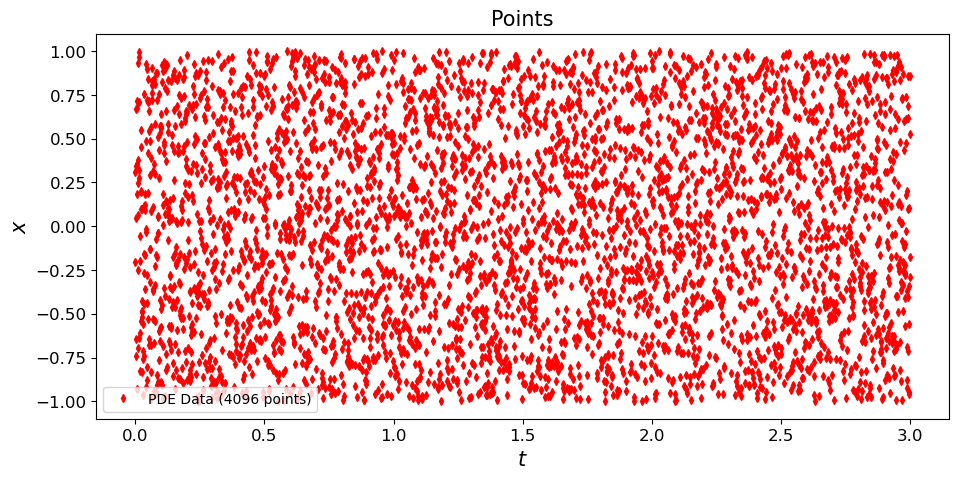

In [17]:
""" The aesthetic setting has changed. """



fig = plt.figure(figsize=(11, 5))
ax = fig.add_subplot(1, 1, 1)
#
ax.plot(ptsPDE[:, 0], ptsPDE[:, 1], 
    'rd', label = 'PDE Data (%d points)' % (ptsPDE.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0

)

ax.set_xlabel('$t$', size=15)
ax.set_ylabel('$x$', size=15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.legend()
ax.set_title('Points', fontsize = 15) # font size doubled
ax.tick_params(labelsize=12)
#
plt.show()

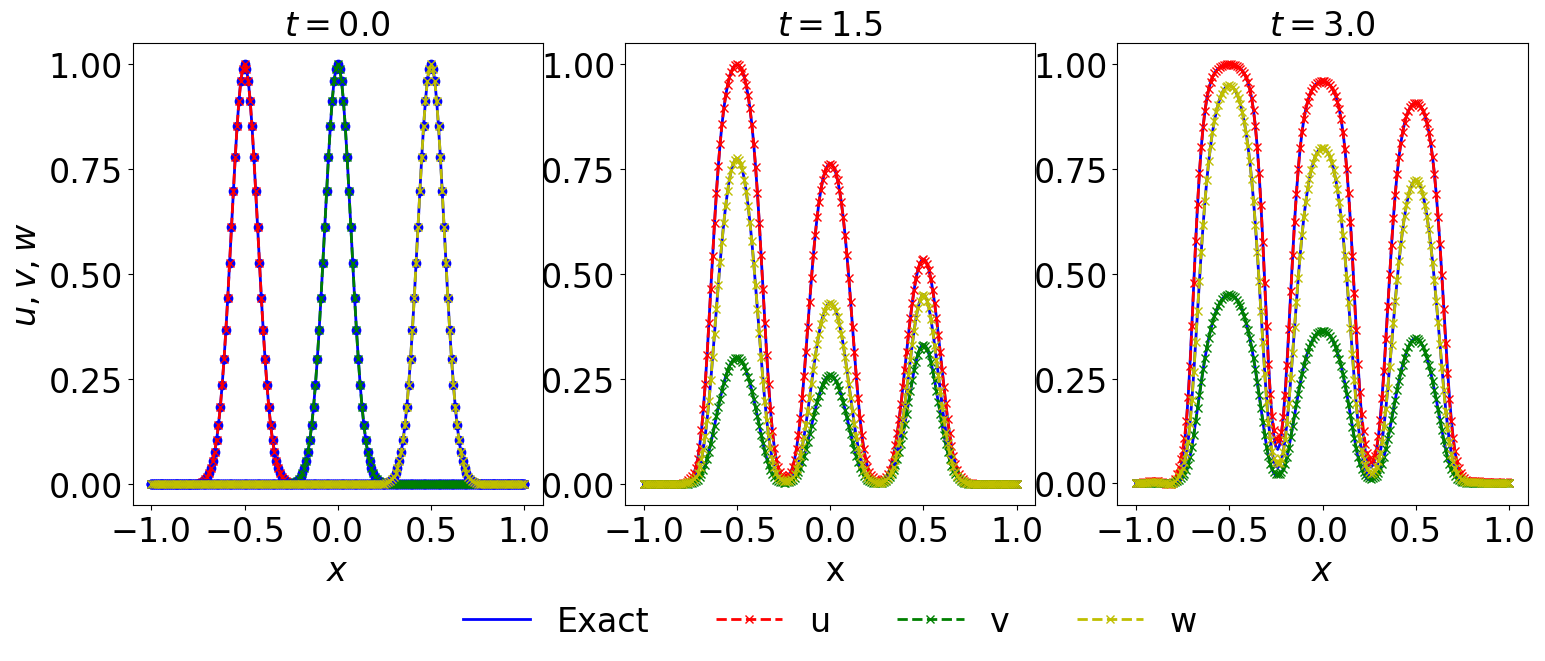

In [55]:


""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(18, 6))
#
ax = plt.subplot(1, 3, 1)
ax.plot(x2, u_sol[0,:], 'bo-', linewidth = 2)       
ax.plot(x, u_pred[:, 0], 'rx--', linewidth = 2, label = 'u')
ax.plot(x2, v_sol[0,:], 'bo-', linewidth = 2, label = 'Exact')       
ax.plot(x, v_pred[:, 0], 'gx--', linewidth = 2, label = 'v')
ax.plot(x2, w_sol[0,:], 'bo-', linewidth = 2)       
ax.plot(x, w_pred[:, 0], 'yx--', linewidth = 2, label = 'w')
ax.set_xlabel('$x$')
ax.set_ylabel('$u,v,w$')    
ax.set_title('$t = %.1f$' %(t[0]), fontsize = 24)
 
plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(24)

ax = plt.subplot(1, 3, 2)
ax.plot(x2,u_sol[150,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x, u_pred[:, 150], 'rx--', linewidth = 2, label = 'u')
ax.plot(x2,v_sol[150,:], 'b-', linewidth = 2)       
ax.plot(x, v_pred[:, 150], 'gx--', linewidth = 2, label = 'v')
ax.plot(x2,w_sol[150,:], 'b-', linewidth = 2)       
ax.plot(x, w_pred[:, 150], 'yx--', linewidth = 2, label = 'w')

ax.set_xlabel(' x')


ax.set_title('$t = %.1f$' %(t[150]), fontsize = 24)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 24}
)
plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(24)

ax = plt.subplot(1, 3, 3)
ax.plot(x2,u_sol[300,:], 'b-', linewidth = 2)       
ax.plot(x, u_pred[:, 300], 'rx--', linewidth = 2, label = 'u')
ax.plot(x2,v_sol[300,:], 'b-', linewidth = 2)       
ax.plot(x, v_pred[:, 300], 'gx--', linewidth = 2, label = 'v')
ax.plot(x2,w_sol[300,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x, w_pred[:, 300], 'yx--', linewidth = 2, label = 'w')
ax.set_xlabel('$x$')


ax.set_title('$t = %.1f$' %(t[300]), fontsize = 24)
plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(24)

plt.show()
fig.savefig('fig:BZ_all.png',format='png')

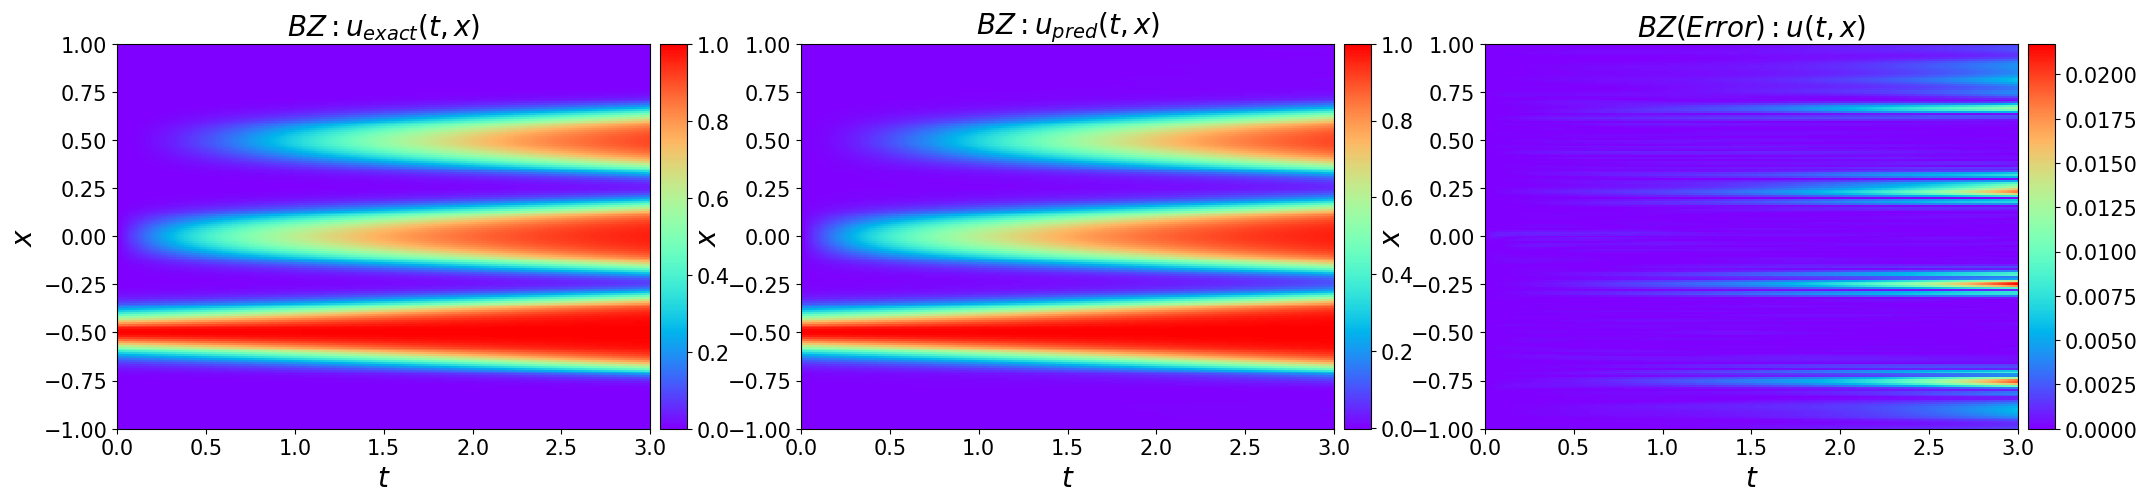

In [60]:
fig = plt.figure(figsize=(25, 5))

ax=plt.subplot(1, 3, 1)
h = ax.imshow(u_sol.T, interpolation='nearest', cmap='rainbow', 
              extent=[tlo, thi, x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 




ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)

ax.set_title('$BZ: u_{exact}(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

ax=plt.subplot(1, 3, 2)
h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
              extent=[tlo, thi, x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 




ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)

ax.set_title('$BZ:u_{pred}(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

ax=plt.subplot(1, 3, 3)
h = ax.imshow(np.abs(u_pred-u_sol.T), interpolation='nearest', cmap='rainbow', 
              extent=[tlo, thi, x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 




ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)

ax.set_title('$BZ(Error):u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()
fig.savefig('fig:BZ_utx_3.png',format='png')


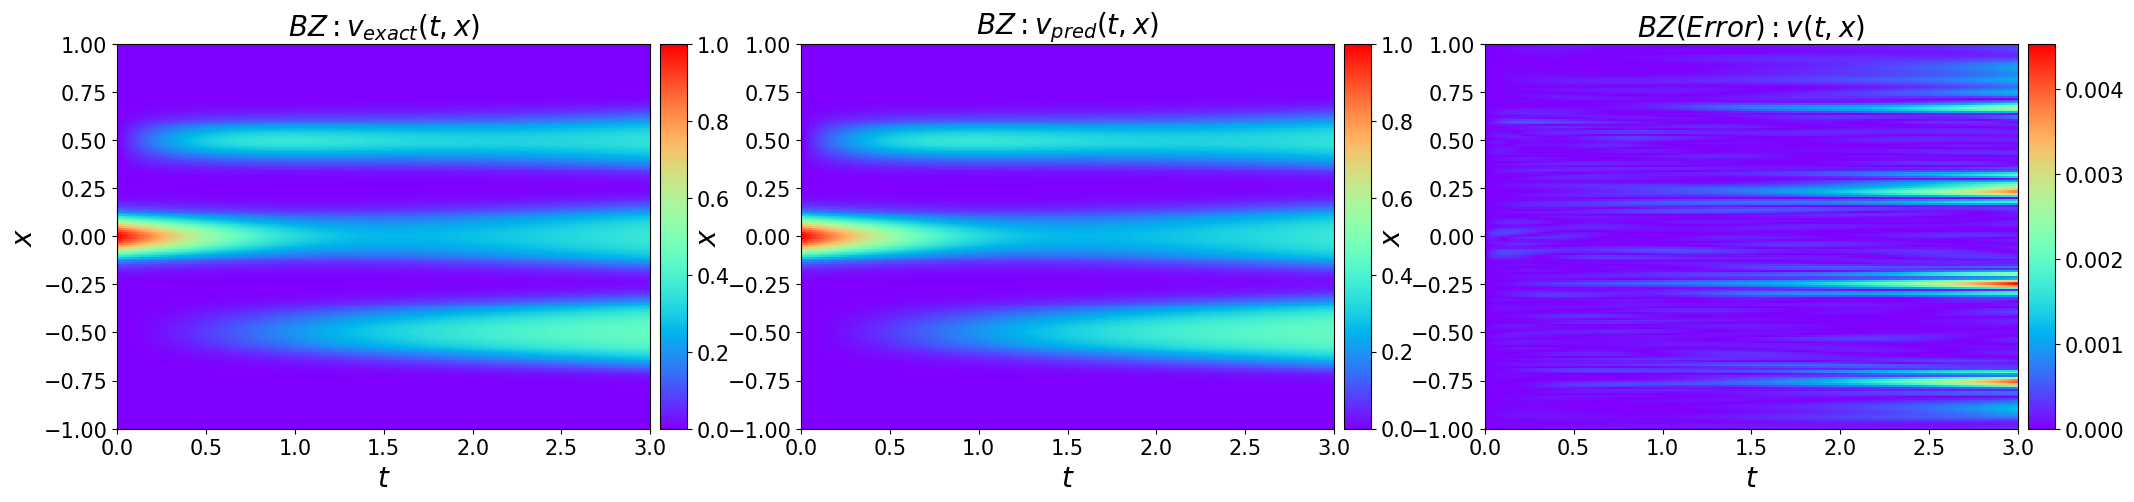

In [61]:
fig = plt.figure(figsize=(25, 5))

ax=plt.subplot(1, 3, 1)
h = ax.imshow(v_sol.T, interpolation='nearest', cmap='rainbow', 
              extent=[tlo, thi, x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 




ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)

ax.set_title('$BZ: v_{exact}(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

ax=plt.subplot(1, 3, 2)
h = ax.imshow(v_pred, interpolation='nearest', cmap='rainbow', 
              extent=[tlo, thi, x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 





ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)

ax.set_title('$BZ:v_{pred}(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

ax=plt.subplot(1, 3, 3)
h = ax.imshow(np.abs(v_pred-v_sol.T), interpolation='nearest', cmap='rainbow', 
              extent=[tlo, thi, x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 





ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)

ax.set_title('$BZ(Error):v(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()
fig.savefig('fig:BZ_vtx_3.png',format='png')


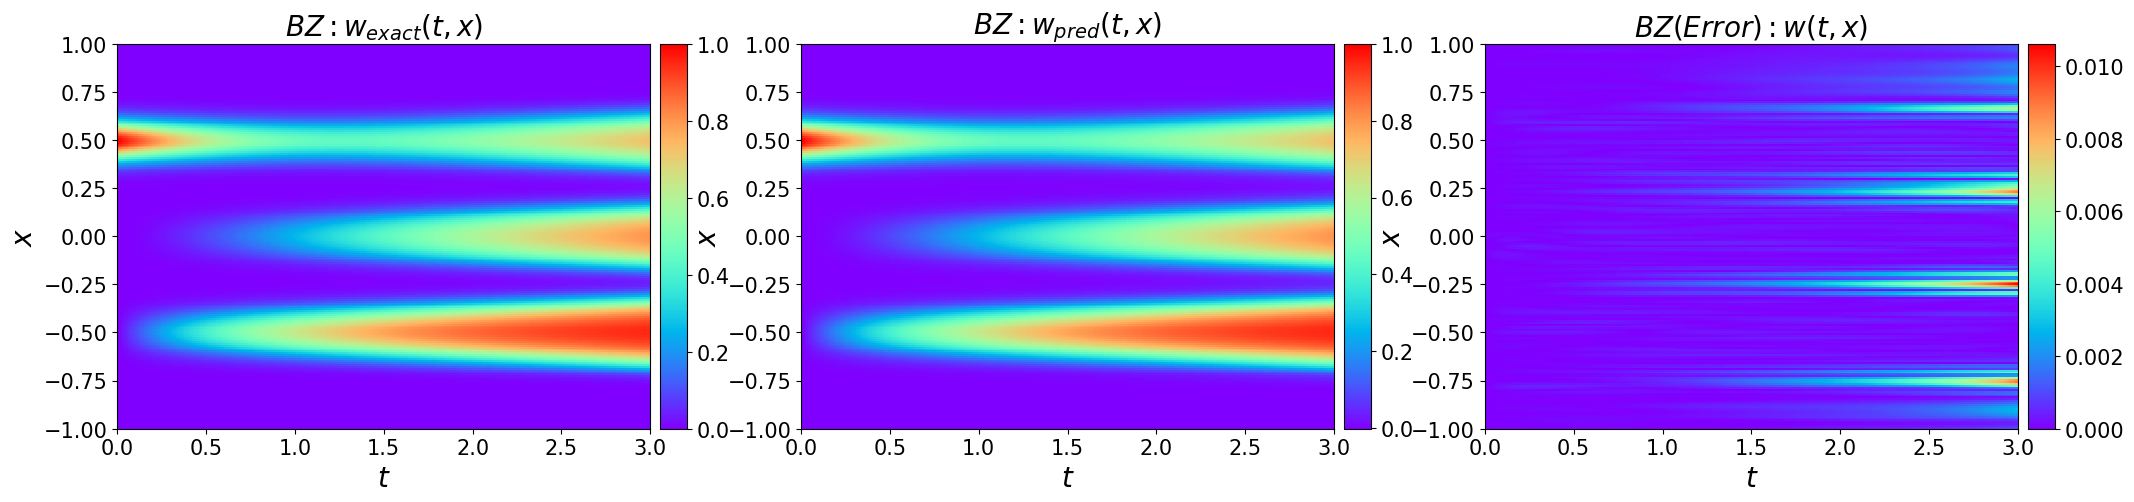

In [62]:
fig = plt.figure(figsize=(25, 5))

ax=plt.subplot(1, 3, 1)
h = ax.imshow(w_sol.T, interpolation='nearest', cmap='rainbow', 
              extent=[tlo, thi, x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 



ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)

ax.set_title('$BZ: w_{exact}(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

ax=plt.subplot(1, 3, 2)
h = ax.imshow(w_pred, interpolation='nearest', cmap='rainbow', 
              extent=[tlo, thi, x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 





ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)

ax.set_title('$BZ:w_{pred}(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

ax=plt.subplot(1, 3, 3)
h = ax.imshow(np.abs(w_pred-w_sol.T), interpolation='nearest', cmap='rainbow', 
              extent=[tlo, thi, x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 




ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)

ax.set_title('$BZ(Error):w(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()
fig.savefig('fig:BZ_wtx_3.png',format='png')
